# <u>Startle Response Analysis</u>
*Lara Kolb*

---

# Imports

Import missing packages by opening the console and entering `pip install MODULENAME` for all modules found below. For example, to install `pandas`, enter `pip install pandas`.

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from scipy.stats import linregress, spearmanr


# Configuration

Sorted by importance. Change `input_folder` to the folder containing your data.

In [2]:
# Basic Settings
input_folder = "2022" # - - - - - - - - - - - - -  folder containing your data files; set to "" to use example data
output_folder = "Output 2022" # - - - - - - - - - - folder to save generated images
example_folder = "15740400" # - - - - - - - -  folder containing the exemplary data files; fallback if input_folder is ""
exemplary_output_folder = "Exemplary Output" # folder to save generated images for exemplary data
repetition_count = 10 # - - - - - - - - - - -  number of repetitions per experiment
animal_no_from_table = False # - - - - - - - - set to True if animal numbers are to be taken from the Animal.No. column in the data table; False to extract from filename  

# Debugging
verbose = True # - - - - - - - - - - - - - -  enables more output messages which can help identify problems; the notebook will only return errors if False
discard_peakless = True # - - - - - - - - - - discard recordings without peaks from analysis
example_number = 33 # - - - - - - - - - - -   index of the trial used for the example plot

# Processing Settings
detection_threshold = 24 # - - - - - - - - -  threshold multiplier for detecting peaks, ValueG has to exceed k times the background noise per animal
length = 500 # - - - - - - - - - - - - - - -  length of the time window in milliseconds (both before and after the startle)
background_offset = 200 # - - - - - - - - - - measure background noise up to this many ms before the startle time (increase if a prepulse is played this or further away from the startle)
detection_offset = 100 # - - - - - - - - - -  check for signal up to this many ms after the startle time (for detection)
peak_window = 100 # - - - - - - - - - - - - - search for the maximum peak in this many ms after the startle time

# Filter Settings
bp_lowcut = 1.0 # - - - - - - - - - - - - - - low cut frequency for bandpass filter in Hz
bp_highcut = 120.0 # - - - - - - - - - - - -  high cut frequency for bandpass filter in Hz
notch_low = 40.0 # - - - - - - - - - - - - -  low cut frequency for notch filter in Hz
notch_high = 55.0 # - - - - - - - - - - - - - high cut frequency for notch filter in Hz
notch_order = 1 # - - - - - - - - - - - - - - order (strength) of the notch filter
order = 4 # - - - - - - - - - - - - - - - - - order (strength) of the Butterworth filters

# Welch PSD settings
nperseg = 1024 # - - - - - - - - - - - - - -  number of data points per segment for FFT computation (higher = better frequency resolution but worse time resolution)
noverlap = nperseg // 2 # - - - - - - - - - - number of overlapping points between segments (50% overlap reduces variance in PSD estimate)

# Smoothing settings
smoothing_enabled = True # - - - - - - - - -  enable smoothing of the signal
smoothing_window = 5 # - - - - - - - - - - -  size of the smoothing window in ms

# CSV file settings (0-indexed)
data_start = 5 # - - - - - - - - - - - - - -  row where data starts
animal_column = 1 # - - - - - - - - - - - - - column for Anim.No.
name_column = 16 # - - - - - - - - - - - - -  column for Trial
value_column = 19 # - - - - - - - - - - - - - column for ValueG

In [3]:
# Dictionary linking animal number and sex
sex_dict = {
    # 2022
    "25":   "female",
    "26":   "female",
    "27":   "male",
    "28":   "male",
    "66":   "female",
    "67":   "female",
    
    # 2025
    "1":    "female",
    "2":    "male",
    "4":    "male",
    "6":    "female",
    "10":   "female",
    "15":   "male",
    
    # 2026
    "43":   "male",
    "44":   "male",
    "45":   "male",
    "46":   "male",
    "47":   "female",
    "48":   "female",
    "49":   "female",
    "93":   "female",
    "94":   "female",
    "95":   "female",
    "96":   "female"
}

In [4]:
# Startle times in ms
startle_times = {
    # 2025
    "gap_depth":        10100,
    "gap_duration_10":  10060,
    "gap_duration_20":  10070,
    "gap_duration_4":   10054,
    "gap_duration_50":  10100,
    "gap_duration_8":   10058,
    "offset_ASR":       10010,
    
    # control
    "ASR_control":      10000,
    "tone_in_noise":    10100,
    
    # offsets
    "offset_PPI_4":     10004,
    "offset_PPI_6":     10006,
    "offset_PPI_8":     10008,
    "offset_PPI_10":    10010,
    "offset_PPI_12":    10012,
    "offset_PPI_14":    10014,
    "offset_PPI_16":    10016,
    "offset_PPI_18":    10018,
    "offset_PPI_20":    10020,
    "offset_PPI_50":    10050,
    
    # 2022
    "OFFSET_4":         [1000, 21020],
    "OFFSET_6":         [1000, 21020],
    "OFFSET_8":         [1000, 21020],
    "OFFSET_10":        [1000, 21020],
    "OFFSET_12":        [1000, 21020],
    "OFFSET_14":        [1000, 21020],
    "OFFSET_16":        [1000, 21020]
}

---

# Data Filtering and Slicing

The raw data has to be filtered, then taken the absolute value of before being sliced into different segments per trial.

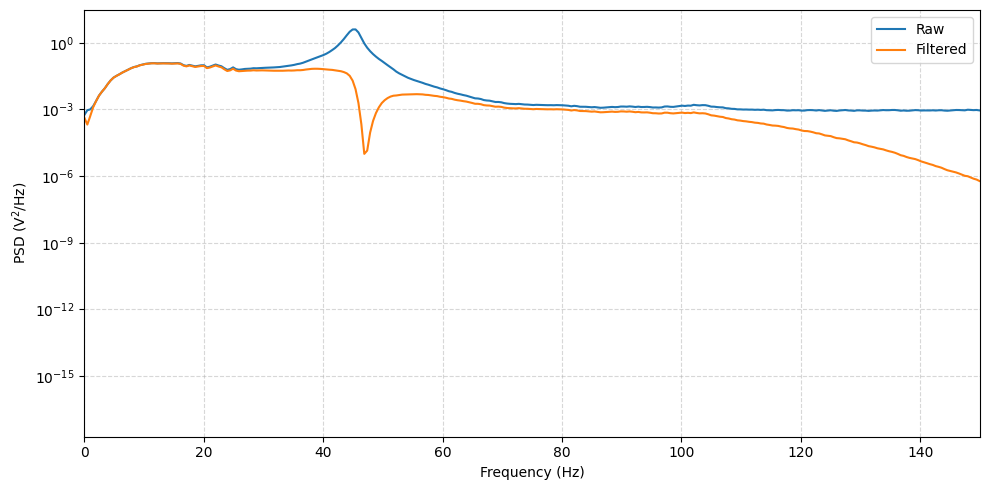

Saved PSD plot: Output 2022\Animal25_November07_PSD.png
Dropping unknown trial labels (not in startle_times): ['1', 'Trial']
Processed 818 segments from 21 files

Missing repetitions:
  OFFSET_10: 4/10
  OFFSET_12: 4/10
  OFFSET_14: 6/10
  OFFSET_16: 6/10
  OFFSET_4: 6/10
  OFFSET_6: 5/10
  OFFSET_8: 6/10


In [5]:
mpl.rcParams["text.usetex"] = False


os.makedirs(output_folder, exist_ok=True) if input_folder != "" else os.makedirs(exemplary_output_folder, exist_ok=True)


first_psd_saved = False


# --- Filter functions ---
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandstop(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a


def apply_filters(signal, fs):
    # Ensure numeric array (coerce bad strings to NaN, then interpolate/zero-fill)
    signal = pd.to_numeric(np.asarray(signal).ravel(), errors='coerce').astype(np.float64)
    if not np.isfinite(signal).all():
        signal = pd.Series(signal).interpolate(limit_direction='both').fillna(0.0).to_numpy()


    # Bandpass 1-120 Hz
    b_bp, a_bp = butter_bandpass(bp_lowcut, bp_highcut, fs, order)
    filtered = filtfilt(b_bp, a_bp, signal)
    # Notch 40-55 Hz
    b_notch, a_notch = butter_bandstop(notch_low, notch_high, fs, notch_order)
    filtered = filtfilt(b_notch, a_notch, filtered)
    # Smoothing (moving average, 5 ms window)
    if smoothing_enabled:
        window_size = max(1, int(fs * (smoothing_window / 1000.0)))
        filtered = uniform_filter1d(filtered, size=window_size)
    return filtered


# --- Process files and build library ---
segments = {}
startles = {}


files = [f for f in os.listdir(input_folder) if f.lower().endswith(".csv")] if input_folder != "" else [f for f in os.listdir(example_folder) if f.lower().endswith(".csv")]


for filename in files:
    filepath = os.path.join(input_folder if input_folder != "" else example_folder, filename)
    
    # Load CSV and skip nonsensical rows
    df = pd.read_csv(filepath, low_memory=False, skiprows=[0, 2])
    
    # Extract animal number and date from filename
    animal_number = df.iloc[data_start + 1, animal_column] if animal_no_from_table else filename.split('_')[0].replace('Animal', '')
    
    date = filename[:-4].split('_')[1]
    animal_str = f"Animal{animal_number}" 
    # Convert value column to numeric
    df.iloc[:, value_column] = pd.to_numeric(df.iloc[:, value_column], errors='coerce')
    signal = df.iloc[:, value_column].values
    
    # Compute sampling frequency (2ms intervals = 500 Hz)
    fs = 500.0  
    
    # --- Apply bandpass + notch filter + smoothing ---
    filtered_signal = apply_filters(signal, fs)
    
    # --- PSD plot for first file only ---
    if not first_psd_saved:
        # Compute PSD on signals WITHOUT absolute value for proper frequency analysis
        f_raw, Pxx_raw = welch(signal, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann')
        f_filt, Pxx_filt = welch(filtered_signal, fs=fs, nperseg=nperseg, noverlap=noverlap, window='hann')
        
        plt.figure(figsize=(10,5))
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.semilogy(f_raw, Pxx_raw, label="Raw")
        plt.semilogy(f_filt, Pxx_filt, label="Filtered")
        plt.xlim([0, 150])
        plt.xlabel("Frequency (Hz)")
        plt.ylabel(r"PSD (V$^2$/Hz)")
        plt.legend()
        plt.tight_layout()
        
        base_name = os.path.splitext(filename)[0]
        psd_png = os.path.join(output_folder, base_name + "_PSD.png") if input_folder != "" else os.path.join(exemplary_output_folder, base_name + "_PSD.png")
        plt.savefig(psd_png)
        plt.show()
        
        if verbose:
            print(f"Saved PSD plot: {psd_png}")
        first_psd_saved = True
    
    # Take absolute value after filtering 
    filtered_signal = np.abs(filtered_signal)
    df.iloc[:, value_column] = filtered_signal
    
    # --- Segment the data by trial ---
    df['trial'] = df.iloc[:, name_column]
    df = df[df['trial'].notna()].copy()  # drop rows without trial labels
    df['trial'] = df['trial'].astype(str).str.strip()
    # Drop rows where trial is literally the string "nan" after astype
    df = df[df['trial'].str.lower() != 'nan'].copy()
    # Keep only known trials
    unknown_trials = sorted(set(df['trial']) - set(startle_times.keys()))
    if verbose and unknown_trials:
        print(f"Dropping unknown trial labels (not in startle_times): {unknown_trials}")
    df = df[df['trial'].isin(startle_times.keys())].copy()
    
    df['trial_shift'] = df['trial'].shift(1)
    df['new_segment'] = df['trial'] != df['trial_shift']
    df['segment_id'] = df['new_segment'].cumsum()
    
    repetition = {}
    
    for segment_id, segment_df in df.groupby('segment_id'):
        trial_name = segment_df.iloc[0]['trial']
        repetition[trial_name] = repetition.get(trial_name, 0) + 1
        
        segment_startle = startle_times.get(trial_name)
        if segment_startle is None:
            raise Exception(f"Missing startle time for {trial_name}. Please make sure it is included in the startle_times dictionary.")
        
        segment_name = f"{animal_str}_{date}_{trial_name}_Rep{repetition[trial_name]}"
        
        segment_length = len(segment_df)
        time_col = np.arange(0, segment_length * 2, 2)
        segment_data = pd.DataFrame({
            0: time_col,
            1: segment_df.iloc[:, value_column].values
        })
        
        segments[segment_name] = segment_data
        startles[segment_name] = segment_startle


# Count repetitions per experiment
counts = Counter([segment_df.iloc[0]['trial'] for _, segment_df in df.groupby('segment_id')])


if verbose: 
    print(f"Processed {len(segments)} segments from {len(files)} files")
    print("\nMissing repetitions:") if any(count < repetition_count for count in counts.values()) else print("\nAll experiments have the correct number of repetitions.")
    for name, count in sorted(counts.items()):
        print(f"  {name}: {count}/{repetition_count}") if count < repetition_count else None

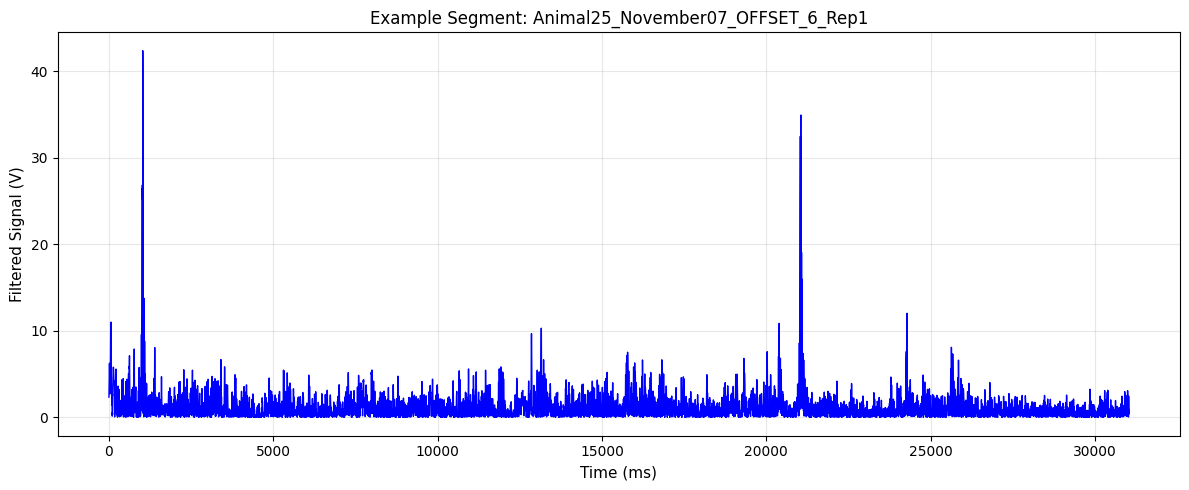

Total segments: 818
Example: Animal25_November07_OFFSET_6_Rep1
Shape: (15520, 2)


In [6]:
# Plot an example segment
example_key = list(segments.keys())[0]
df = segments[example_key]

plt.figure(figsize=(12, 5))
plt.plot(df[0], df[1], 'b-', linewidth=1)
plt.xlabel('Time (ms)', fontsize=11)
plt.ylabel('Filtered Signal (V)', fontsize=11)
plt.title(f'Example Segment: {example_key}', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total segments: {len(segments)}")
print(f"Example: {example_key}")
print(f"Shape: {df.shape}")

### This gives us two libraries that we can use going forward:

- **`segments`**: Dictionary containing filtered signal data for each trial segment
  - Keys: `"Animal{N}_{Date}_{TrialName}_Rep{R}"` (e.g., `"Animal1_April16_ASR_control_Rep1"`)
  - Values: pandas DataFrame with columns `[0]` = time (ms), `[1]` = filtered signal (absolute value)

- **`startles`**: Dictionary mapping each segment name to its startle time (ms)

The data is pre-filtered using:
- Bandpass filter: 1-120 Hz
- Notch filter: 40-55 Hz
- Moving average smoothing: 5 ms window

---

# Signal Detection

To decide which recordings do not meet the detection criteria and need to be discarded, we need to measure the background noise per animal, multiply it by a certain factor and then remove all segments that do not reach this value.

In [7]:
# Get background noise per animal
animal_noise_results = {}

experiment_keys = [t[0] for t in sorted(counts.items())]

for key in segments.keys():
    # Extract animal name
    animal = key.split('_')[0]

    # Find experiment prefix in key
    matching_prefix = None
    for exp_key in experiment_keys:
        if exp_key in key:
            matching_prefix = exp_key
            break

    if matching_prefix is None:
        raise Exception(f"No experiment prefix found for key: {key}")

    startle_time = startle_times.get(matching_prefix)[1] if isinstance(startle_times.get(matching_prefix), list) else startle_times.get(matching_prefix)
    if startle_time is None:
        raise Exception(f"No startle time found for experiment: {matching_prefix}")

    df = segments[key]

    # Convert time column to numeric
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')

    start_time = 0
    end_time = startle_time - background_offset  # measure up to 200ms before the startle
    if end_time <= start_time:
        raise Exception(f"Invalid time window for {key}: startle_time={startle_time}")

    mask = (df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] < end_time)
    background_window = df.loc[mask].iloc[:, 1]

    if background_window.empty:
        raise Exception(f"No data in background window for {key}")

    noise_level = background_window.std()

    # Store noise levels per animal and experiment across repetitions
    animal_noise_results.setdefault(animal, {}).setdefault(matching_prefix, []).append(noise_level)

# Median noise across repetitions per experiment per animal
animal_noise_median = {}
for animal, exp_dict in animal_noise_results.items():
    animal_noise_median[animal] = {}
    for exp, noise_list in exp_dict.items():
        animal_noise_median[animal][exp] = float(np.median(noise_list))

# Median noise across experiments per animal
animal_noise = {}
for animal, exp_dict in animal_noise_median.items():
    all_exp_values = list(exp_dict.values())
    if all_exp_values:
        animal_noise[animal] = round(float(np.median(all_exp_values)), 2)
    else:
        animal_noise[animal] = None

if verbose:
    print(f"Collected background noise for {len(animal_noise)} animals:")
    print(animal_noise)

Collected background noise for 4 animals:
{'Animal25': 1.14, 'Animal26': 0.46, 'Animal27': 0.66, 'Animal28': 0.51}


In [8]:
# Cut the segments
import re

adjusted_segments = {}
for entry in segments:
    df = segments[entry]
    reference_time = startles[entry]
    
    # If reference_time is a list, process both entries
    if isinstance(reference_time, list):
        # First, process the first entry (offset) without renaming
        ref_time_offset = reference_time[0]
        start_time = ref_time_offset - length
        end_time = ref_time_offset + length
        filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)].copy()
        filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - ref_time_offset
        filtered_df.reset_index(drop=True, inplace=True)
        adjusted_segments[entry] = filtered_df
        
        # Then, process the second entry (control) with renaming
        reference_time = reference_time[1]

    # Filter the data to get rows within the 1000 ms before and after the reference time
    start_time = reference_time - length
    end_time = reference_time + length

    # Filter the dataframe to include only the data within the time range
    filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)].copy()

    # Adjust the time column to set the reference time to 0
    filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time

    filtered_df.reset_index(drop=True, inplace=True)
    
    # Rename OFFSET_X to ASR_control in the key
    new_key = re.sub(r'OFFSET_\d+', 'ASR_control', entry)
    
    # If the key already exists, increment the Rep number until we find an available one
    if new_key in adjusted_segments:
        # Extract the base key and current rep number
        match = re.match(r'(.+_Rep)(\d+)$', new_key)
        if match:
            base_key = match.group(1)
            rep_num = int(match.group(2))
            
            # Find the next available rep number
            while new_key in adjusted_segments:
                rep_num += 1
                new_key = f"{base_key}{rep_num}"
    
    adjusted_segments[new_key] = filtered_df

if verbose:
    asr_count = sum(1 for k in adjusted_segments.keys() if 'ASR_control' in k)
    print(f"Adjusted {len(adjusted_segments)} segments ({asr_count} ASR_control segments after renaming)")

Adjusted 1636 segments (818 ASR_control segments after renaming)


In [9]:
animal_thresholds = {animal: animal_noise[animal] * detection_threshold for animal in animal_noise}
print(f"Animal thresholds for detection: {animal_thresholds}")

Animal thresholds for detection: {'Animal25': 27.36, 'Animal26': 11.040000000000001, 'Animal27': 15.84, 'Animal28': 12.24}


In [10]:
signal_results = {}

for key, df in adjusted_segments.items():
    animal = key.split('_')[0]
    noise = animal_noise.get(animal)

    # Set post-startle window
    mask = (df.iloc[:, 0] >= 0) & (df.iloc[:, 0] <= detection_offset)
    window = df.loc[mask].iloc[:, 1]

    # Threshold detection
    detected = not window.empty and window.max() > detection_threshold * noise
    signal_results[key] = detected

if verbose: print(signal_results)

{'Animal25_November07_OFFSET_6_Rep1': np.True_, 'Animal25_November07_ASR_control_Rep1': np.True_, 'Animal25_November07_OFFSET_8_Rep1': np.True_, 'Animal25_November07_ASR_control_Rep2': np.True_, 'Animal25_November07_OFFSET_4_Rep1': np.True_, 'Animal25_November07_ASR_control_Rep3': np.False_, 'Animal25_November07_OFFSET_8_Rep2': np.False_, 'Animal25_November07_ASR_control_Rep4': np.True_, 'Animal25_November07_OFFSET_12_Rep1': np.True_, 'Animal25_November07_ASR_control_Rep5': np.True_, 'Animal25_November07_OFFSET_10_Rep1': np.True_, 'Animal25_November07_ASR_control_Rep6': np.True_, 'Animal25_November07_OFFSET_8_Rep3': np.True_, 'Animal25_November07_ASR_control_Rep7': np.True_, 'Animal25_November07_OFFSET_14_Rep1': np.True_, 'Animal25_November07_ASR_control_Rep8': np.True_, 'Animal25_November07_OFFSET_10_Rep2': np.True_, 'Animal25_November07_ASR_control_Rep9': np.False_, 'Animal25_November07_OFFSET_16_Rep1': np.False_, 'Animal25_November07_ASR_control_Rep10': np.False_, 'Animal25_November

In [11]:
animal_hits = {}
animal_misses = {}

for key, detected in signal_results.items():
    animal = key.split('_')[0]
    if detected:
        animal_hits[animal] = animal_hits.get(animal, 0) + 1
    else:
        animal_misses[animal] = animal_misses.get(animal, 0) + 1

animal_hit_rate = {}
for animal in animal_hits.keys() | animal_misses.keys():
    hits = animal_hits.get(animal, 0)
    misses = animal_misses.get(animal, 0)
    total = hits + misses
    animal_hit_rate[animal] = round(hits / total, 2) if total > 0 else None

if verbose:
    print("\nHit Rate per Animal:")
    print("-" * 47)
    for animal in sorted(animal_hit_rate.keys()):
        hits = animal_hits.get(animal, 0)
        total = hits + animal_misses.get(animal, 0)
        rate_pct = animal_hit_rate[animal] * 100 if animal_hit_rate[animal] else 0
        print(f"  {animal:15s}: {rate_pct:5.1f}%  ({hits}/{total} detected)")
    print("-" * 47)


Hit Rate per Animal:
-----------------------------------------------
  Animal25       :  73.0%  (325/448 detected)
  Animal26       :  46.0%  (171/370 detected)
  Animal27       :  64.0%  (286/446 detected)
  Animal28       :  69.0%  (258/372 detected)
-----------------------------------------------


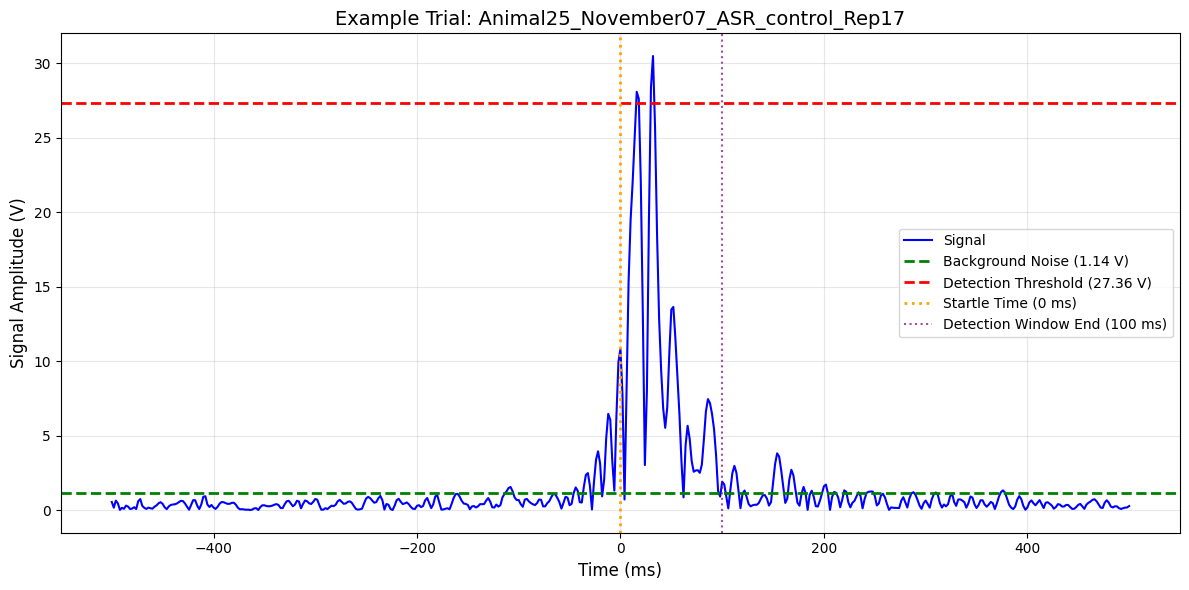


Example Trial: Animal25_November07_ASR_control_Rep17
Background Noise: 1.14 V
Detection Threshold: 27.36 V
Signal Detected: True


In [12]:
# Plot an example startle trial
example_key = list(adjusted_segments.keys())[example_number]
df = adjusted_segments[example_key]
times = df[0]
values = df[1]

# Get animal-specific noise and threshold
animal = example_key.split('_')[0]
noise_level = animal_noise[animal]
detection_thresh = animal_thresholds[animal]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(times, values, 'b-', linewidth=1.5, label='Signal')

# Show background noise and detection threshold
plt.axhline(y=noise_level, color='green', linestyle='--', linewidth=2, label=f'Background Noise ({noise_level:.2f} V)')
plt.axhline(y=detection_thresh, color='red', linestyle='--', linewidth=2, label=f'Detection Threshold ({detection_thresh:.2f} V)')

# Mark startle time
plt.axvline(x=0, color='orange', linestyle=':', linewidth=2, label='Startle Time (0 ms)')

# Mark detection window
plt.axvline(x=detection_offset, color='purple', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Detection Window End ({detection_offset} ms)')

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Signal Amplitude (V)', fontsize=12)
plt.title(f'Example Trial: {example_key}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'example_startle_trace.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'example_startle_trace.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nExample Trial: {example_key}")
print(f"Background Noise: {noise_level:.2f} V")
print(f"Detection Threshold: {detection_thresh:.2f} V")
print(f"Signal Detected: {signal_results.get(example_key, False)}")# Compiling

---

In [13]:
if discard_peakless:
    excluded_counts = {}
    for k, df in adjusted_segments.items():
        if not signal_results.get(k, False):
            parts = k.split('_')
            experiment_parts = []
            for p in parts[2:]:
                if p.startswith("Rep"):
                    break
                experiment_parts.append(p)
            experiment = "_".join(experiment_parts)
            excluded_counts[experiment] = excluded_counts.get(experiment, 0) + 1

    if verbose:
        print("\nExcluded Segments (did not meet threshold):")
        print("-" * 48)
        for experiment, count in sorted(excluded_counts.items()):
            print(f"  {experiment:30s}: {count:3d} segments")
        print("-" * 48)
        print(f"  Total excluded: {sum(excluded_counts.values())} segments")

    # Discard entries without peaks
    data = {k: v for k, v in adjusted_segments.items() if signal_results.get(k, False)}
else:
    data = adjusted_segments


Excluded Segments (did not meet threshold):
------------------------------------------------
  ASR_control                   : 224 segments
  OFFSET_10                     :  54 segments
  OFFSET_12                     :  48 segments
  OFFSET_14                     :  53 segments
  OFFSET_16                     :  68 segments
  OFFSET_4                      :  50 segments
  OFFSET_6                      :  45 segments
  OFFSET_8                      :  54 segments
------------------------------------------------
  Total excluded: 596 segments


In [14]:
main_reaction = {}

for entry in data:
    times = data[entry][0]
    values = data[entry][1]

    # Only consider peaks within 0-100ms after startle for peakTime and peakValue
    peak_window_mask = (times >= 0) & (times <= peak_window)
    values_peak_window = values[peak_window_mask]
    times_peak_window = times[peak_window_mask]

    # Find peak only in 0-100ms window
    if len(values_peak_window) > 0:
        max_index_in_peak_window = np.argmax(values_peak_window)
        max_value = values_peak_window.iloc[max_index_in_peak_window]
        max_time = times_peak_window.iloc[max_index_in_peak_window]
    else:
        max_value = np.nan
        max_time = np.nan

    # Save result
    main_reaction[entry] = {
        "peakTime": [int(max_time) if not np.isnan(max_time) else None],
        "peakValue": [int(max_value) if not np.isnan(max_value) else None]
    }

if verbose: print(f"Created reaction data for {len(main_reaction)} segments.")

Created reaction data for 1040 segments.


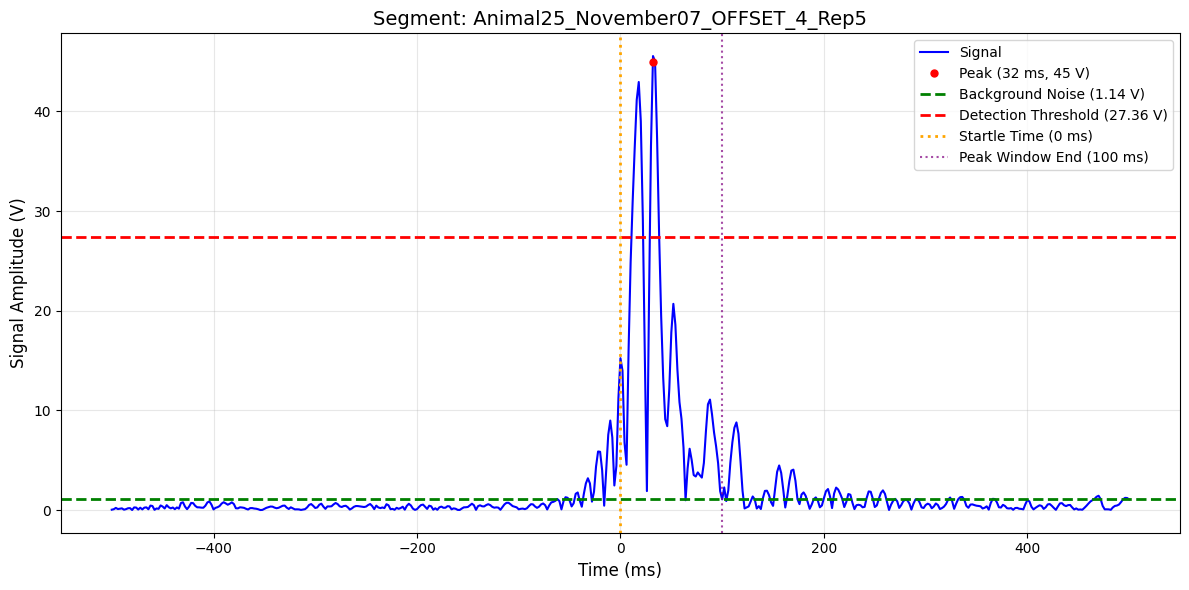


Segment: Animal25_November07_OFFSET_4_Rep5
Peak Time: 32 ms
Peak Value: 45 V
Background Noise: 1.14 V
Detection Threshold: 27.36 V


In [15]:
# Plot exemplary segment
example_key = list(data.keys())[example_number]
df = data[example_key]
times = df[0]
values = df[1]

# Get the peak info
peak_time = main_reaction[example_key]["peakTime"][0]
peak_value = main_reaction[example_key]["peakValue"][0]

# Get animal-specific noise and threshold
animal = example_key.split('_')[0]
noise_level = animal_noise[animal]
detection_thresh = animal_thresholds[animal]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(times, values, 'b-', linewidth=1.5, label='Signal')

# Mark the peak
if peak_time is not None and peak_value is not None:
    plt.plot(peak_time, peak_value, 'ro', markersize=5, label=f'Peak ({peak_time} ms, {peak_value} V)')

# Show background noise and detection threshold
plt.axhline(y=noise_level, color='green', linestyle='--', linewidth=2, label=f'Background Noise ({noise_level:.2f} V)')
plt.axhline(y=detection_thresh, color='red', linestyle='--', linewidth=2, label=f'Detection Threshold ({detection_thresh:.2f} V)')

# Mark startle time
plt.axvline(x=0, color='orange', linestyle=':', linewidth=2, label='Startle Time (0 ms)')

# Mark peak window
plt.axvline(x=peak_window, color='purple', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Peak Window End ({peak_window} ms)')

plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Signal Amplitude (V)', fontsize=12)
plt.title(f'Segment: {example_key}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'trace.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'trace.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSegment: {example_key}")
print(f"Peak Time: {peak_time} ms")
print(f"Peak Value: {peak_value} V")
print(f"Background Noise: {noise_level:.2f} V")
print(f"Detection Threshold: {detection_thresh:.2f} V")

---

# %PPI Calculation

We calculate the percent prepulse inhibition (%PPI) by comparing:
- **S** (startle response alone): ASR_control experiments
- **PPS** (prepulse + startle): tone_in_noise and offset_PPI experiments

For this, we use this formula: %PPI = 100 × (S - PPS) / S

In [16]:
# Helper function to extract experiment name from segment key
def get_experiment_name(key):
    parts = key.split('_')
    experiment_parts = []
    for p in parts[2:]:
        if p.startswith("Rep"):
            break
        experiment_parts.append(p)
    return "_".join(experiment_parts)

# Categorize all segments
asr_control_data = {}
tin_data = {}
offset_data = {}
discarded = {}

for key, value in main_reaction.items():
    exp_name = get_experiment_name(key)
    
    if exp_name == "ASR_control":
        asr_control_data[key] = value
    elif exp_name == "tone_in_noise":
        tin_data[key] = value
    elif exp_name.startswith("offset_PPI") or exp_name.startswith("OFFSET_"):
        offset_data[key] = value
    else:
        discarded[key] = value

print(f"Categorized segments:")
print(f"   ASR Control: {len(asr_control_data)} segments")
print(f"   Tone in Noise: {len(tin_data)} segments")
print(f"   Offset PPI: {len(offset_data)} segments")
print(f"   Discarded: {len(discarded)} segments")

Categorized segments:
   ASR Control: 594 segments
   Tone in Noise: 0 segments
   Offset PPI: 446 segments
   Discarded: 0 segments


In [17]:
# Build DataFrames for %PPI calculation
# Extract animal, date, experiment, and peakValue from each group

def build_dataframe(data_dict):
    rows = []
    for key, metrics in data_dict.items():
        parts = key.split('_')
        animal = parts[0]
        date = parts[1]
        exp_name = get_experiment_name(key)
        peak_value = metrics['peakValue'][0] if metrics['peakValue'][0] is not None else np.nan
        
        rows.append({
            'animal': animal,
            'date': date,
            'experiment': exp_name,
            'peakValue': peak_value,
            'key': key
        })
    return pd.DataFrame(rows)

# Build DataFrames
asr_df = build_dataframe(asr_control_data)
tin_df = build_dataframe(tin_data)
offset_df = build_dataframe(offset_data)

# Aggregate ASR_control by (animal, date) - average across repetitions
asr_avg = asr_df.groupby(['animal', 'date'], as_index=False).agg({
    'peakValue': 'mean'
})

print(f"\nData summary:")
print(f"   ASR Control: {len(asr_df)} recordings → {len(asr_avg)} unique (animal, date) pairs")
print(f"   Tone in Noise: {len(tin_df)} recordings")
print(f"   Offset PPI: {len(offset_df)} recordings")


Data summary:
   ASR Control: 594 recordings → 21 unique (animal, date) pairs
   Tone in Noise: 0 recordings
   Offset PPI: 446 recordings


In [18]:
# Calculate %PPI for TIN and Offset experiments
def calc_percent_ppi(asr_avg, exp_df, label):
    """
    Calculate %PPI = 100 * (S - PPS) / S
    where S = ASR_control peakValue, PPS = prepulse experiment peakValue
    """
    # Merge on animal and date
    merged = pd.merge(
        exp_df, asr_avg,
        on=['animal', 'date'],
        suffixes=('_pps', '_s')
    )
    
    # Filter valid data
    merged = merged[
        pd.notna(merged['peakValue_s']) & 
        pd.notna(merged['peakValue_pps']) & 
        (merged['peakValue_s'] != 0)
    ].copy()
    
    # Calculate %PPI
    merged['percent_ppi'] = 100 * (merged['peakValue_s'] - merged['peakValue_pps']) / merged['peakValue_s']
    
    # Extract trailing number for offset experiments
    merged['trailing_number'] = merged['experiment'].str.extract(r'_(\d+)$')[0].astype(float)
    
    if verbose:
        neg_count = (merged['percent_ppi'] < 0).sum()
        avg_ppi = merged['percent_ppi'].mean()
        print(f"\n{label}:")
        print(f"   Total comparisons: {len(merged)}")
        print(f"   Negative %PPI: {neg_count}")
        print(f"   Mean %PPI: {avg_ppi:.2f}%")
    
    return merged[['animal', 'date', 'experiment', 'percent_ppi', 'trailing_number', 'key']]

# Calculate %PPI
# Only calculate TIN if data exists
if len(tin_df) > 0:
    ppi_tin = calc_percent_ppi(asr_avg, tin_df, "Tone in Noise")
else:
    ppi_tin = pd.DataFrame(columns=['animal', 'date', 'experiment', 'percent_ppi', 'trailing_number', 'key'])
    if verbose:
        print("\nNo Tone in Noise data found - skipping TIN analysis")

ppi_offset = calc_percent_ppi(asr_avg, offset_df, "Offset PPI")


No Tone in Noise data found - skipping TIN analysis

Offset PPI:
   Total comparisons: 446
   Negative %PPI: 140
   Mean %PPI: 9.49%


In [19]:
# Add sex information to %PPI data
# Define colors for male and female
male_col = "#1f77b4"  # Blue
female_col = "#ff7f0e"  # Orange

def add_sex_column(df):
    df = df.copy()
    df['animal_num'] = df['animal'].str.extract(r'(\d+)')[0]
    df['sex'] = df['animal_num'].map(sex_dict)
    return df

# Only add sex column if TIN data exists
if len(ppi_tin) > 0:
    ppi_tin_sex = add_sex_column(ppi_tin)
else:
    ppi_tin_sex = pd.DataFrame(columns=['animal', 'date', 'experiment', 'percent_ppi', 'trailing_number', 'key', 'animal_num', 'sex'])

ppi_offset_sex = add_sex_column(ppi_offset)

# Print sex-based statistics
def print_sex_stats(df, label):
    male_avg = df[df['sex'] == 'male']['percent_ppi'].mean()
    female_avg = df[df['sex'] == 'female']['percent_ppi'].mean()
    overall_avg = df['percent_ppi'].mean()
    
    print(f"\n{label} by sex:")
    print(f"   Male:    {male_avg:.2f}%")
    print(f"   Female:  {female_avg:.2f}%")
    print(f"   Overall: {overall_avg:.2f}%")

if len(ppi_tin_sex) > 0:
    print_sex_stats(ppi_tin_sex, "Tone in Noise %PPI")
print_sex_stats(ppi_offset_sex, "Offset PPI %PPI")


Offset PPI %PPI by sex:
   Male:    13.91%
   Female:  4.67%
   Overall: 9.49%


In [20]:
# Plot %PPI for Tone in Noise (only if data exists)
if len(ppi_tin_sex) > 0:
    fig, ax = plt.subplots(figsize=(8, 6))

    male_data = ppi_tin_sex[ppi_tin_sex['sex'] == 'male']['percent_ppi']
    female_data = ppi_tin_sex[ppi_tin_sex['sex'] == 'female']['percent_ppi']

    # Boxplot
    bp = ax.boxplot([male_data, female_data], positions=[1, 2], widths=0.6,
                     patch_artist=True, boxprops=dict(facecolor='white'))

    # Scatter overlay
    for i, (sex, color) in enumerate([('male', male_col), ('female', female_col)], start=1):
        yvals = ppi_tin_sex[ppi_tin_sex['sex'] == sex]['percent_ppi']
        xvals = i + 0.1 * np.random.randn(len(yvals))
        ax.scatter(xvals, yvals, color=color, edgecolor='black', 
                   alpha=0.6, s=50, linewidth=0.5, label=sex)

    ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylabel('%PPI', fontsize=12)
    ax.set_xlabel('Sex', fontsize=12)
    ax.set_title('Tone in Noise %PPI', fontsize=14)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Male', 'Female'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'ppi_tone_in_noise.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'ppi_tone_in_noise.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nTone in Noise:")
    print(f"   Male (n={len(male_data)}): {male_data.mean():.2f}% ± {male_data.std():.2f}%")
    print(f"   Female (n={len(female_data)}): {female_data.mean():.2f}% ± {female_data.std():.2f}%")
else:
    print("\nSkipping Tone in Noise plot - no data available")


Skipping Tone in Noise plot - no data available


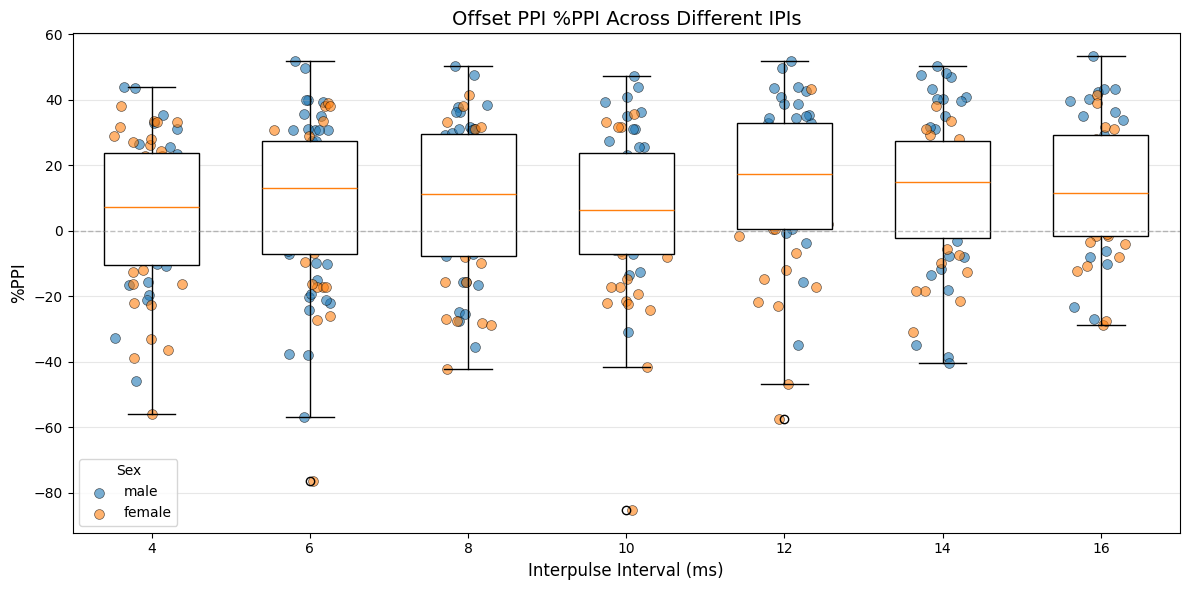


%PPI by Offset IPI:
   4 ms (n=68): 5.73% ± 22.88%
   6 ms (n=77): 8.65% ± 24.65%
   8 ms (n=66): 9.24% ± 22.81%
   10 ms (n=60): 5.66% ± 23.79%
   12 ms (n=56): 13.69% ± 23.89%
   14 ms (n=66): 12.24% ± 22.00%
   16 ms (n=53): 12.36% ± 20.55%


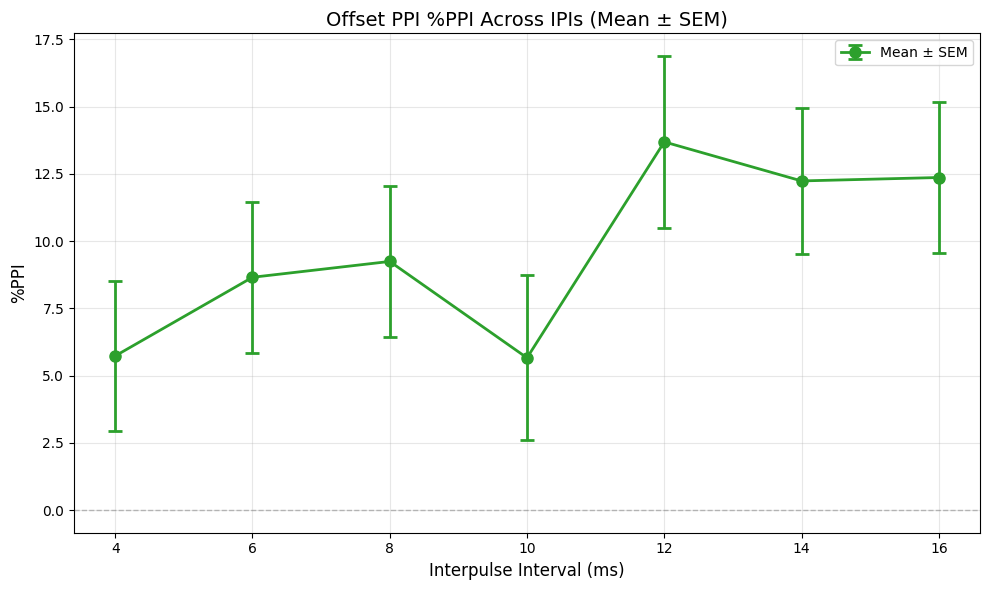

In [21]:
# Plot %PPI across different Offset IPIs
offset_numbers = sorted(ppi_offset_sex['trailing_number'].dropna().unique())

fig, ax = plt.subplots(figsize=(12, 6))

# Boxplot by offset IPI
positions = list(range(1, len(offset_numbers) + 1))
data_by_offset = [ppi_offset_sex[ppi_offset_sex['trailing_number'] == num]['percent_ppi'].values 
                  for num in offset_numbers]

bp = ax.boxplot(data_by_offset, positions=positions, widths=0.6,
                patch_artist=True, boxprops=dict(facecolor='white'))

# Scatter overlay with sex coloring
for i, num in enumerate(offset_numbers, start=1):
    offset_data = ppi_offset_sex[ppi_offset_sex['trailing_number'] == num]
    for sex, color in [('male', male_col), ('female', female_col)]:
        yvals = offset_data[offset_data['sex'] == sex]['percent_ppi']
        if len(yvals) > 0:
            xvals = i + 0.1 * np.random.randn(len(yvals))
            ax.scatter(xvals, yvals, color=color, edgecolor='black',
                      alpha=0.6, s=50, linewidth=0.5,
                      label=sex if i == 1 else None)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('%PPI', fontsize=12)
ax.set_xlabel('Interpulse Interval (ms)', fontsize=12)
ax.set_title('Offset PPI %PPI Across Different IPIs', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels([f'{int(num)}' for num in offset_numbers])
ax.legend(title='Sex')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'ppi_offset_ipis.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'ppi_offset_ipis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print statistics per offset
print(f"\n%PPI by Offset IPI:")
for num in offset_numbers:
    offset_subset = ppi_offset_sex[ppi_offset_sex['trailing_number'] == num]['percent_ppi']
    print(f"   {int(num)} ms (n={len(offset_subset)}): {offset_subset.mean():.2f}% ± {offset_subset.std():.2f}%")

# Line plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))

means = []
errors = []
for num in offset_numbers:
    subset = ppi_offset_sex[ppi_offset_sex['trailing_number'] == num]['percent_ppi']
    means.append(subset.mean())
    errors.append(subset.sem())  # Standard error of mean

ax.errorbar(offset_numbers, means, yerr=errors, marker='o', markersize=8, 
            linewidth=2, capsize=5, capthick=2, color='#2ca02c', 
            ecolor='#2ca02c', label='Mean ± SEM')

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Interpulse Interval (ms)', fontsize=12)
ax.set_ylabel('%PPI', fontsize=12)
ax.set_title('Offset PPI %PPI Across IPIs (Mean ± SEM)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'ppi_offset_lineplot.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'ppi_offset_lineplot.png'), dpi=300, bbox_inches='tight')
plt.show() 

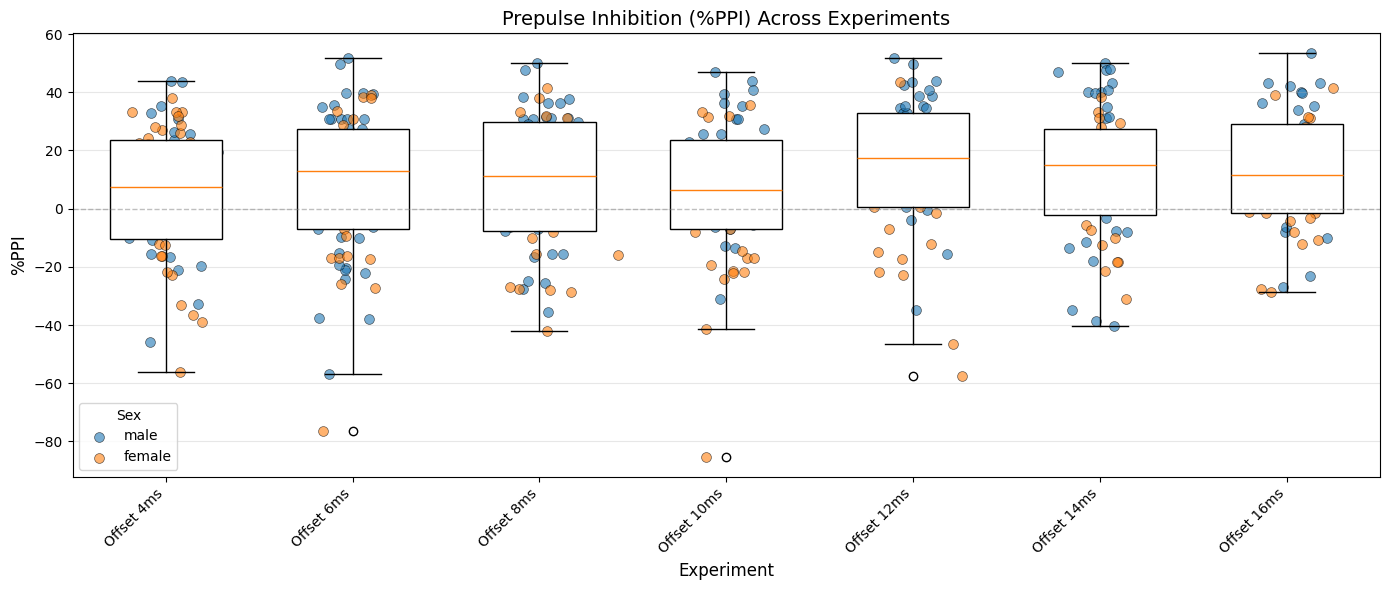


%PPI Summary (all experiments):
   Offset 4ms: 5.73% ± 22.88% (n=68)
   Offset 6ms: 8.65% ± 24.65% (n=77)
   Offset 8ms: 9.24% ± 22.81% (n=66)
   Offset 10ms: 5.66% ± 23.79% (n=60)
   Offset 12ms: 13.69% ± 23.89% (n=56)
   Offset 14ms: 12.24% ± 22.00% (n=66)
   Offset 16ms: 12.36% ± 20.55% (n=53)


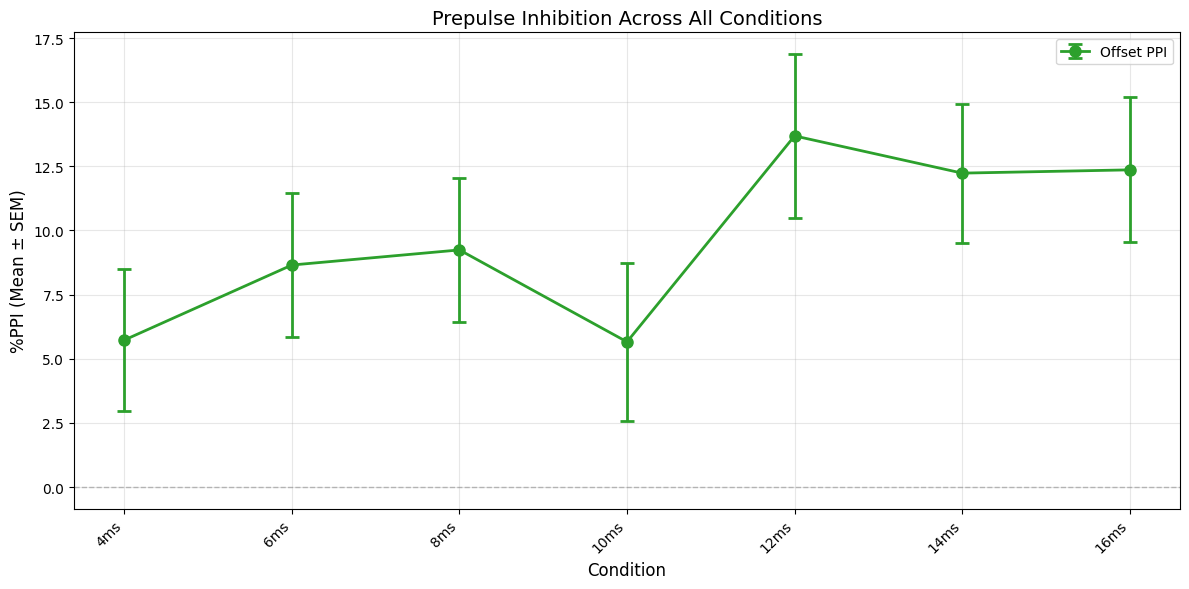

In [22]:
# Combined plot: TIN + all Offset IPIs
# Combine TIN and Offset data (only include TIN if it exists)
if len(ppi_tin_sex) > 0:
    ppi_tin_plot = ppi_tin_sex.copy()
    ppi_tin_plot['experiment_label'] = 'TIN (80 dB)'
    ppi_tin_plot['sort_key'] = 0
    
    ppi_offset_plot = ppi_offset_sex.copy()
    ppi_offset_plot['experiment_label'] = ppi_offset_plot['trailing_number'].apply(lambda x: f'Offset {int(x)}ms')
    ppi_offset_plot['sort_key'] = ppi_offset_plot['trailing_number']
    
    combined = pd.concat([ppi_tin_plot, ppi_offset_plot], ignore_index=True)
else:
    ppi_offset_plot = ppi_offset_sex.copy()
    ppi_offset_plot['experiment_label'] = ppi_offset_plot['trailing_number'].apply(lambda x: f'Offset {int(x)}ms')
    ppi_offset_plot['sort_key'] = ppi_offset_plot['trailing_number']
    
    combined = ppi_offset_plot

combined = combined.sort_values('sort_key')

# Get unique experiments in order
exp_labels = combined['experiment_label'].unique()

fig, ax = plt.subplots(figsize=(14, 6))

# Boxplot
positions = list(range(1, len(exp_labels) + 1))
data_by_exp = [combined[combined['experiment_label'] == label]['percent_ppi'].values 
               for label in exp_labels]

bp = ax.boxplot(data_by_exp, positions=positions, widths=0.6,
                patch_artist=True, boxprops=dict(facecolor='white'))

# Scatter overlay
for i, label in enumerate(exp_labels, start=1):
    exp_data = combined[combined['experiment_label'] == label]
    for sex, color in [('male', male_col), ('female', female_col)]:
        yvals = exp_data[exp_data['sex'] == sex]['percent_ppi']
        if len(yvals) > 0:
            xvals = i + 0.1 * np.random.randn(len(yvals))
            ax.scatter(xvals, yvals, color=color, edgecolor='black',
                      alpha=0.6, s=50, linewidth=0.5,
                      label=sex if i == 1 else None)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('%PPI', fontsize=12)
ax.set_xlabel('Experiment', fontsize=12)
ax.set_title('Prepulse Inhibition (%PPI) Across Experiments', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(exp_labels, rotation=45, ha='right')
ax.legend(title='Sex')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'ppi_combined_all_experiments.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'ppi_combined_all_experiments.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n%PPI Summary (all experiments):")
for label in exp_labels:
    subset = combined[combined['experiment_label'] == label]['percent_ppi']
    print(f"   {label}: {subset.mean():.2f}% ± {subset.std():.2f}% (n={len(subset)})")

# Line plot with error bars for all experiments
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for offset experiments
offset_means = []
offset_sems = []
offset_ipis = []
for num in sorted(ppi_offset_sex['trailing_number'].dropna().unique()):
    subset = ppi_offset_sex[ppi_offset_sex['trailing_number'] == num]['percent_ppi']
    offset_means.append(subset.mean())
    offset_sems.append(subset.sem())
    offset_ipis.append(num)

# Plot TIN as separate marker (only if data exists)
if len(ppi_tin_sex) > 0:
    tin_mean = ppi_tin_sex['percent_ppi'].mean()
    tin_sem = ppi_tin_sex['percent_ppi'].sem()
    ax.errorbar([0], [tin_mean], yerr=[tin_sem], marker='s', markersize=10,
                linewidth=0, capsize=5, capthick=2, color='#d62728',
                ecolor='#d62728', label='TIN (80 dB)', zorder=3)
    
    # X-axis labels include TIN
    ax.set_xticks([0] + offset_ipis)
    ax.set_xticklabels(['TIN'] + [f'{int(x)}ms' for x in offset_ipis], rotation=45, ha='right')
else:
    # X-axis labels only show offset IPIs
    ax.set_xticks(offset_ipis)
    ax.set_xticklabels([f'{int(x)}ms' for x in offset_ipis], rotation=45, ha='right')

# Plot Offset IPIs as connected line
ax.errorbar(offset_ipis, offset_means, yerr=offset_sems, marker='o', markersize=8,
            linewidth=2, capsize=5, capthick=2, color='#2ca02c',
            ecolor='#2ca02c', label='Offset PPI', zorder=2)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('%PPI (Mean ± SEM)', fontsize=12)
ax.set_title('Prepulse Inhibition Across All Conditions', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'ppi_all_conditions_lineplot.png'), dpi=300, bbox_inches='tight') if input_folder != "" else plt.savefig(os.path.join(exemplary_output_folder, 'ppi_all_conditions_lineplot.png'), dpi=300, bbox_inches='tight')
plt.show()

---

In [ ]:
# Calculate mean %PPI for animal 27
animal_27_data = ppi_offset_sex[ppi_offset_sex['animal'] == 'Animal27']
mean_ppi = animal_27_data['percent_ppi'].mean()
print(f"Mean %PPI for Animal 27: {mean_ppi}")

Mean %PPI for Animal 27: 12.797559630251847


---

# Analysis

In [23]:
from scipy.stats import shapiro
import scipy.stats as stats

# Function to perform normality test and print results
def test_normality(data, name):
    """
    Perform Shapiro-Wilk test and interpret results.
    """
    # Remove NaN values
    data_clean = data[~np.isnan(data)]
    
    if len(data_clean) < 3:
        print(f"\n{name}:")
        print(f"  Sample size too small (n={len(data_clean)}) for normality testing")
        return None, None
    
    # Shapiro-Wilk test
    stat, p_value = shapiro(data_clean)
    
    print(f"\n{name}:")
    print(f"  Sample size: n={len(data_clean)}")
    print(f"  Shapiro-Wilk statistic: {stat:.4f}")
    print(f"  p-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"  Result: Data is NOT normally distributed (p < 0.05)")
        print(f"  Recommendation: Consider non-parametric tests")
    else:
        print(f"  Result: Data is consistent with normal distribution (p ≥ 0.05)")
        print(f"  Recommendation: Parametric tests are appropriate")
    
    return stat, p_value

# Function to create Q-Q plot
def plot_qq(data, name, ax):
    """
    Create Q-Q plot for visual assessment of normality.
    """
    data_clean = data[~np.isnan(data)]
    stats.probplot(data_clean, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {name}')
    ax.grid(True, alpha=0.3)

print("="*70)
print("NORMALITY TESTING FOR KEY VARIABLES")
print("="*70)

# Test normality of %PPI data for different experiments
if len(ppi_tin_sex) > 0 and ppi_tin_sex is not None:
    test_normality(ppi_tin_sex['percent_ppi'].values, "Tone in Noise %PPI (all)")
    test_normality(ppi_tin_sex[ppi_tin_sex['sex'] == 'male']['percent_ppi'].values, 
                   "Tone in Noise %PPI (males)")
    test_normality(ppi_tin_sex[ppi_tin_sex['sex'] == 'female']['percent_ppi'].values, 
                   "Tone in Noise %PPI (females)")

test_normality(ppi_offset_sex['percent_ppi'].values, "Offset PPI %PPI (all)")
test_normality(ppi_offset_sex[ppi_offset_sex['sex'] == 'male']['percent_ppi'].values, 
               "Offset PPI %PPI (males)")
test_normality(ppi_offset_sex[ppi_offset_sex['sex'] == 'female']['percent_ppi'].values, 
               "Offset PPI %PPI (females)")

# Test normality for each IPI separately
print("\n" + "-"*70)
print("NORMALITY BY IPI (Offset PPI)")
print("-"*70)
for ipi in sorted(ppi_offset_sex['trailing_number'].unique()):
    subset = ppi_offset_sex[ppi_offset_sex['trailing_number'] == ipi]['percent_ppi'].values
    test_normality(subset, f"Offset PPI at {int(ipi)}ms IPI")

print("="*70)

NORMALITY TESTING FOR KEY VARIABLES

Offset PPI %PPI (all):
  Sample size: n=446
  Shapiro-Wilk statistic: 0.9742
  p-value: 0.000000
  Result: Data is NOT normally distributed (p < 0.05)
  Recommendation: Consider non-parametric tests

Offset PPI %PPI (males):
  Sample size: n=233
  Shapiro-Wilk statistic: 0.9670
  p-value: 0.000031
  Result: Data is NOT normally distributed (p < 0.05)
  Recommendation: Consider non-parametric tests

Offset PPI %PPI (females):
  Sample size: n=213
  Shapiro-Wilk statistic: 0.9594
  p-value: 0.000009
  Result: Data is NOT normally distributed (p < 0.05)
  Recommendation: Consider non-parametric tests

----------------------------------------------------------------------
NORMALITY BY IPI (Offset PPI)
----------------------------------------------------------------------

Offset PPI at 4ms IPI:
  Sample size: n=68
  Shapiro-Wilk statistic: 0.9654
  p-value: 0.055764
  Result: Data is consistent with normal distribution (p ≥ 0.05)
  Recommendation: Param

In [24]:
# Statistical tests for trend in Offset PPI with increasing IPI

# Prepare data: IPI (x) vs %PPI (y)
ipi_values = ppi_offset_sex['trailing_number'].values
ppi_values = ppi_offset_sex['percent_ppi'].values

# Remove any NaN values
valid_mask = ~np.isnan(ipi_values) & ~np.isnan(ppi_values)
ipi_clean = ipi_values[valid_mask]
ppi_clean = ppi_values[valid_mask]

# Linear regression (parametric test for linear trend)
slope, intercept, r_value, p_value, std_err = linregress(ipi_clean, ppi_clean)

# Spearman correlation (non-parametric test for monotonic relationship)
spearman_rho, spearman_p = spearmanr(ipi_clean, ppi_clean)

# Mann-Kendall test (non-parametric test for monotonic trend)
def mann_kendall_test(x, y):
    """
    Perform Mann-Kendall test for monotonic trend.
    Tests whether y increases or decreases monotonically with x.
    """
    # Sort by x values
    sorted_indices = np.argsort(x)
    y_sorted = y[sorted_indices]
    
    n = len(y_sorted)
    s = 0
    
    # Calculate S statistic
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign(y_sorted[j] - y_sorted[i])
    
    # Calculate variance
    var_s = n * (n - 1) * (2 * n + 5) / 18
    
    # Calculate Z statistic
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # Two-tailed p-value
    from scipy.stats import norm
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    return s, z, p_value

mk_s, mk_z, mk_p = mann_kendall_test(ipi_clean, ppi_clean)

print("STATISTICAL ANALYSIS: Trend in %PPI with Offset IPI")
print("="*60)

print(f"\nLinear Regression (parametric):")
print(f"  Slope: {slope:.4f} %PPI per ms")
print(f"  R²: {r_value**2:.4f}")
print(f"  p-value: {p_value:.6f}")
if p_value < 0.001:
    print(f"  Significance: *** (highly significant)")
elif p_value < 0.01:
    print(f"  Significance: ** (very significant)")
elif p_value < 0.05:
    print(f"  Significance: * (significant)")
else:
    print(f"  Significance: ns (not significant)")

print(f"\nSpearman Rank Correlation (non-parametric):")
print(f"  Rho: {spearman_rho:.4f}")
print(f"  p-value: {spearman_p:.6f}")
if spearman_p < 0.001:
    print(f"  Significance: *** (highly significant)")
elif spearman_p < 0.01:
    print(f"  Significance: ** (very significant)")
elif spearman_p < 0.05:
    print(f"  Significance: * (significant)")
else:
    print(f"  Significance: ns (not significant)")

print(f"\nMann-Kendall Test (monotonic trend):")
print(f"  S statistic: {mk_s:.0f}")
print(f"  Z statistic: {mk_z:.4f}")
print(f"  p-value: {mk_p:.6f}")
if mk_p < 0.001:
    print(f"  Significance: *** (highly significant)")
elif mk_p < 0.01:
    print(f"  Significance: ** (very significant)")
elif mk_p < 0.05:
    print(f"  Significance: * (significant)")
else:
    print(f"  Significance: ns (not significant)")

print("\nInterpretation:")
if slope > 0 and p_value < 0.05:
    print(f"  Linear regression: %PPI INCREASES significantly with longer IPI")
elif slope < 0 and p_value < 0.05:
    print(f"  Linear regression: %PPI DECREASES significantly with longer IPI")
else:
    print(f"  Linear regression: No significant linear trend detected")

if spearman_rho > 0 and spearman_p < 0.05:
    print(f"  Non-parametric: %PPI shows a significant POSITIVE monotonic trend")
    print(f"  (inhibition increases as the interval gets longer)")
elif spearman_rho < 0 and spearman_p < 0.05:
    print(f"  Non-parametric: %PPI shows a significant NEGATIVE monotonic trend")
    print(f"  (inhibition decreases as the interval gets longer)")
else:
    print(f"  Non-parametric: No significant monotonic trend detected")

print("="*60)

STATISTICAL ANALYSIS: Trend in %PPI with Offset IPI

Linear Regression (parametric):
  Slope: 0.5557 %PPI per ms
  R²: 0.0092
  p-value: 0.042669
  Significance: * (significant)

Spearman Rank Correlation (non-parametric):
  Rho: 0.0821
  p-value: 0.083296
  Significance: ns (not significant)

Mann-Kendall Test (monotonic trend):
  S statistic: 5194
  Z statistic: 1.6512
  p-value: 0.098689
  Significance: ns (not significant)

Interpretation:
  Linear regression: %PPI INCREASES significantly with longer IPI
  Non-parametric: No significant monotonic trend detected
